# Load Packages and Data

## Packages

In [7]:
import contextily as ctx
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import numpy as np
import xarray as xr
import os

## Links and Variables

In [8]:
# Data pulled from Community Snow Obs Website
data = 'Mesa_Snow_Heights.geojson'

# boundary KML File form snowex Flights
boundaries = 'Boundary_KMLs/PLAN_1585_v01_all_swaths_Jan22-May7.kml'

# Make output directory
try: 
    os.mkdir('/output')
    print('made directory')
except:
    print('didn''t make a directory')


didnt make a directory


## Read in the Datasets

In [9]:
# Read in the CSO Data
df = gpd.read_file(data)

# use fiona to load in the kml files from the flight boundaries
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
flight_bound = gpd.read_file(boundaries, driver='KML')

# Clean up the string a bit
flight_bound['Name'] = flight_bound['Name'].str[0:-18]

flight_bound['Name'][0]

flight_bound

,Name,Description,geometry
0,alamos,,"POLYGON ((-106.54263 35.69443, -106.30516 35.6..."
1,irnton,,"POLYGON ((-107.90969 37.71257, -107.67724 37.6..."
2,peeler,,"POLYGON ((-107.14932 39.11146, -107.32840 38.9..."
3,peeler,,"POLYGON ((-106.85130 38.77560, -106.67695 38.9..."
4,grmesa,,"POLYGON ((-107.87156 38.94870, -107.85343 39.1..."
5,grmesa,,"POLYGON ((-108.38061 39.11693, -108.39273 38.9..."
6,rockmt,,"POLYGON ((-105.91885 40.72144, -106.11447 40.6..."
7,fraser,,"POLYGON ((-105.44841 40.05776, -105.59997 40.2..."
8,fraser,,"POLYGON ((-106.03598 39.87864, -105.88277 39.7..."
9,rockmt,,"POLYGON ((-105.74316 40.25068, -105.54790 40.3..."


# Merge the polygons

In [10]:
# Create subset for boundary to play with
FB = flight_bound
# Join the flights (JF) by using dissolve command
JF = FB.dissolve( by = 'Name', as_index = False )

# checks
# display(JF)
flight_bound = JF
# JF.groupby('Name').plot(column = 'Name',  
#     facecolor = 'none' , # empty polygons 
#     edgecolor = 'black') # determine the edge color)


## Check the projections and metadata of each dataset

In [11]:
# do the projections match?
TF = flight_bound.crs == df.crs # test if they are equal
print(f'Do the flight and point data have the same projection: {TF} \n')

print('What Projection are they in: ')
print(f'Depth Projection: {df.crs}')
print(f'Flight Projection: {flight_bound.crs}')

Do the flight and point data have the same projection: True 

What Projection are they in: 
Depth Projection: epsg:4326
Flight Projection: epsg:4326


## Visualize

<Figure size 4000x4000 with 0 Axes>

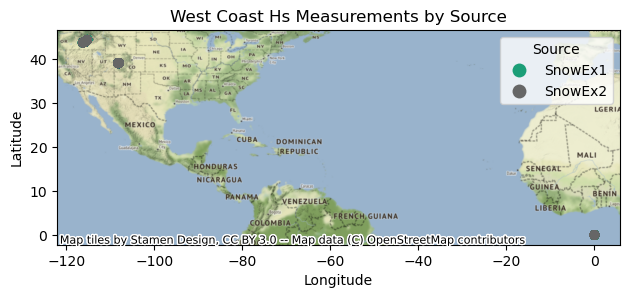

In [12]:
fig = plt.figure(figsize=(40, 40))
ax1 = df.plot(column = 'Source',
    cmap = 'Dark2', # set the colormap 
    legend = True, # Turn on the legend  
    legend_kwds={
        # 'bbox_to_anchor': (0.6 , 0.8) , # push the legend off the map
        'title': 'Source' # Label the legend
        }, 
    )

# Add the basemap
ctx.add_basemap(ax1, # Add to the current axis
    crs=df.crs, # Assign the same CRS as the Dataframe
    source=ctx.providers.Stamen.TerrainBackground) # Determine what the base map is

# labels and titles
plt.title('West Coast Hs Measurements by Source')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
# add the base map
ctx.add_basemap(ax1, crs=df.crs)


plt.tight_layout()
# plt.savefig('output/All_Submitted_Hs.png', dpi = 300)
plt.show()

# Clean

## Clip to the boundaries

In [15]:
# add a site column to the dataframe
df["Site"] = np.nan

# # re-order dataframe
# df = df[['Site' , 'timestamp' , 'elevation' , 'depth'  , '_ms' , 'geometry' , 'source' , 'author' , 'id']]


# set the order of the columns
df = df [['Source' , 'Site' , 'Name' , 'Depth' , 'Altitude (ft)' , 'Accuracy (ft)' , 'Date/Time',
           'Latitude' , 'Longitude' , 'Location' , 'geometry' , 'Description' , 'User' , 'Attachment'	]]

# clip to the boundaries
df = gpd.clip(df , flight_bound) # clip the dataframe to the flight boundaries
df # Run a check of number of rows

# Assign a Site to each point
for index, row in df.iterrows(): # for the indices and rows 
    point = row["geometry"] # pull the geometry to test
    for num, ob in flight_bound.iterrows(): # for ever 
        if point.within(ob["geometry"]): 
            # print(ob["Name"]) 
            df["Site"][index] = ob["Name"]  # set the site label at theindex to the flight boundary name

# df.to_file('/output/All_Hs_Measurements.geojson', driver = 'GeoJSON')
display(df)

C:\Users\Owner\AppData\Local\Temp\ipykernel_22248\610283203.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Site"][index] = ob["Name"]  # set the site label at theindex to the flight boundary name


,Source,Site,Name,Depth,Altitude (ft),Accuracy (ft),Date/Time,Latitude,Longitude,Location,geometry,Description,User,Attachment
0,SnowEx1,lowman,Snow Depth 3166,136,7094.67,NaN,3/18/2021 3:11 PM,44.304410,-115.236476,"44.304410°, -115.236476°",POINT (-115.23648 44.30441),None,None,None
1,SnowEx1,lowman,Snow Depth 3165,130,7093.28,NaN,3/18/2021 3:10 PM,44.304328,-115.236566,"44.304328°, -115.236566°",POINT (-115.23657 44.30433),None,None,None
2,SnowEx1,lowman,Snow Depth 3164,130,7089.20,NaN,3/18/2021 3:09 PM,44.304064,-115.236652,"44.304064°, -115.236652°",POINT (-115.23665 44.30406),None,None,None
3,SnowEx1,lowman,Snow Depth 3163,148,7086.51,NaN,3/18/2021 3:08 PM,44.303959,-115.236645,"44.303959°, -115.236645°",POINT (-115.23665 44.30396),None,None,None
4,SnowEx1,lowman,Snow Depth 3162,152,7088.60,NaN,3/18/2021 3:07 PM,44.303661,-115.236575,"44.303661°, -115.236575°",POINT (-115.23658 44.30366),None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6462,SnowEx2,lowman,Snow Depth 1936,95,6071.29,0.73,2/4/2022 2:45 PM,43.737324,-116.122612,"43.737324°, -116.122612°",POINT (-116.12261 43.73732),None,None,None
6463,SnowEx2,lowman,Snow Depth 1935,100,6074.03,0.60,2/4/2022 2:43 PM,43.737322,-116.122619,"43.737322°, -116.122619°",POINT (-116.12262 43.73732),None,None,None
6464,SnowEx2,lowman,Snow Depth 1945,100,6272.08,0.72,3/4/2022 1:26 PM,43.747420,-116.110559,"43.747420°, -116.110559°",POINT (-116.11056 43.74742),None,None,None
6465,SnowEx2,lowman,Snow Depth 1934,107,6072.15,0.60,2/4/2022 2:43 PM,43.737311,-116.122642,"43.737311°, -116.122642°",POINT (-116.12264 43.73731),None,None,None


## Plot it again

<Figure size 70000x30000 with 0 Axes>

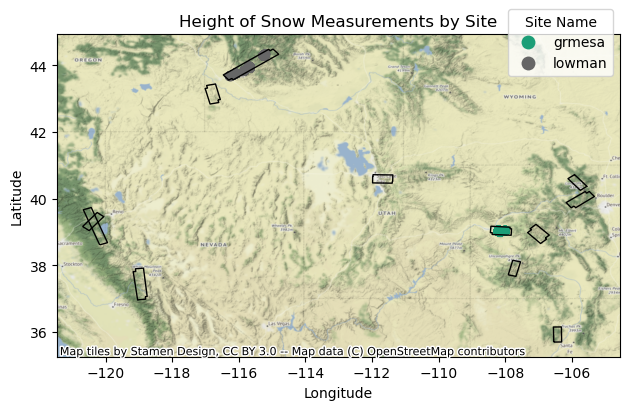

In [16]:
fig = plt.figure(figsize=(700, 300))
# Plot the points
ax1 = df.plot(column = 'Site' , # sorting by the site
    cmap = 'Dark2', # set the colormap 
    legend = True, # Turn on the legend
    legend_kwds={
        'bbox_to_anchor': (1, 1.1) , # push the legend off the map
        'title': 'Site Name' # Label the legend
        }, 
    )
# Plot the boundaries
flight_bound.plot(ax = ax1 , 
    facecolor = 'none' , # empty polygons 
    edgecolor = 'black') # determine the edge color
plt.title('Height of Snow Measurements by Site')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

# add the base map
ctx.add_basemap(ax1, crs=df.crs)
plt.tight_layout()
# plt.savefig('output/All_Sites_Map.png', dpi = 300)
plt.show()


In [28]:
# display(flight_bound) # 4 and 6
# flight_bound.iloc[4].plot()

# for idx in range(len(flight_bound)):

#     # Plot the flight boundaries
flight_bound.iloc[4].plot(
    facecolor = 'none', # make sure there is no fill
    edgecolor='#6a6a6a', # Turn the edges black
    linewidth= 4, # Line width
    )
     
#     # Set the Title for the subplot
#     ax1[idx].set_title(f"{flight_bound.iloc[idx]['Name']}", # Set the title to the Site
#         fontsize = 30) # Set the font size

#     # # Plot tthe base Map
#     ctx.add_basemap(ax1[idx], 
#       crs=df.crs) # set the crs to that of the dataframe
    

# ########################### Plot the Individual Points #######################3

#     # skip the bad ones
#     if flight_bound.iloc[idx]['Name'] == 'silver':
#         continue

#     else:

    
#         # else plot the new ones
#         dnew = df[df['Site'] == flight_bound['Name'][idx] ]
#         dnew.plot(ax=ax1[idx] ,
#             color = 'red')

# plt.suptitle('Mesa Datapoints by Flight Line',  # Set the overall title
#     fontsize = 100) # Fontsize

# plt.tight_layout()
# # plt.savefig('output/Individual_Sites.png', dpi = 300)
# plt.show()

TypeError: no numeric data to plot